In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from matplotlib import ticker

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%%bash

if ! [[ -f ../data/AmpC_screen_table__withscores.csv ]]; then
    sed -e '/no_score/d' ../data/AmpC_screen_table.csv > ../data/AmpC_screen_table__withscores.csv
fi

if ! [[ -f ../data/D4_screen_table__withscores.csv ]]; then
    sed -e '/no_score/d' ../data/D4_screen_table.csv > ../data/D4_screen_table__withscores.csv
fi

if ! [[ -f ../data/4eiy_screen_table__withscores.csv ]]; then
    echo 'zincid,smiles,dockscore' > ../data/4eiy_screen_table__withscores.csv
    for f in ../data/4eiy_screen_table_1M/tables_for_prediction/Morgan_size\=2048_radius\=2/ZINC20_1_full_*__radius\=2__size\=2048__binarised.csv; do
        awk -F ',' 'OFS="," {print $2,$4,$3}' $f | grep -v 'Smiles' >> ../data/4eiy_screen_table__withscores.csv
    done
fi

if ! [[ -f ../data/4eiy_screen_table__withscores_2.csv ]]; then
    echo 'zincid,smiles,dockscore' > ../data/4eiy_screen_table__withscores_2.csv
    for f in ../data/4eiy_screen_table_1M/tables_for_prediction_second/*.csv; do
        awk -F ',' 'OFS="," {print $2,$4,$3}' $f | grep -v 'Smiles' >> ../data/4eiy_screen_table__withscores_2.csv
    done
fi

if ! [[ -f ../data/5zty_screen_table__withscores.csv ]]; then
    echo 'zincid,smiles,dockscore' > ../data/5zty_screen_table__withscores.csv
    for f in ../data/5zty_screen_table_1M/tables_for_prediction/Morgan_size\=2048_radius\=2/ZINC20_1_full_*__radius\=2__size\=2048__binarised.csv; do
        awk -F ',' 'OFS="," {print $2,$4,$3}' $f | grep -v 'Smiles' >> ../data/5zty_screen_table__withscores.csv
    done
fi

In [6]:
%%time

datasets = {
    'AmpC':'data/AmpC_screen_table__withscores.csv',
    'D4':'data/D4_screen_table__withscores.csv',
    '4eiy_1':'data/4eiy_screen_table__withscores.csv',
    '4eiy_2':'data/4eiy_screen_table__withscores_2.csv',
    '5zty':'data/5zty_screen_table__withscores.csv'
           }

dfs = []
for name, path in datasets.items():
    df = dd.read_csv(path)
    df['proj'] = name
    dfs.append(df)

raw_data = dd.concat(dfs).compute(num_workers = 4)

CPU times: user 5min 20s, sys: 37.6 s, total: 5min 57s
Wall time: 4min 48s


In [7]:
raw_data.proj.unique()

array(['AmpC', 'D4', '4eiy_1', '4eiy_2', '5zty'], dtype=object)

# Plot normalized and not normalized data

In [11]:
df = (
    raw_data
    # .sample(500_000)
    .reset_index()
    .drop('index', axis=1)
    .rename(columns={'Score':'dockscore'})
    .drop('hac', axis=1)
    .query('dockscore < 0')
)

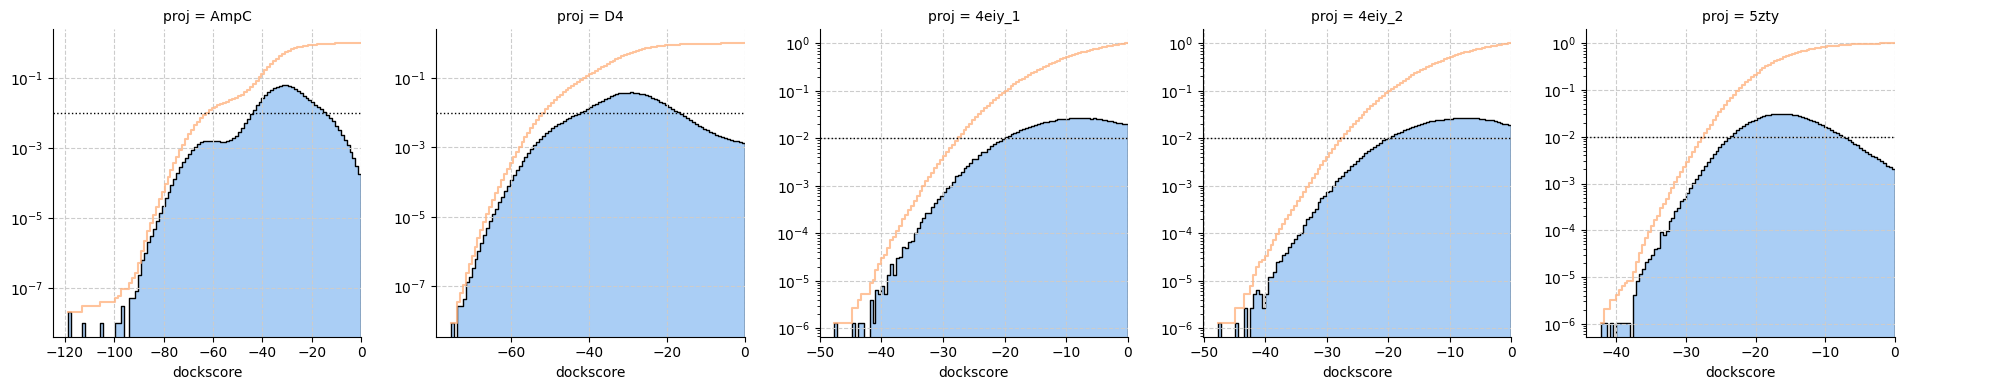

In [13]:
kwa = {
    #     'color':'proj',
    "x": "dockscore",
    "bins": 100,
    "stat": "probability",
}
colors = sns.color_palette("pastel", n_colors=2)

grid = sns.FacetGrid(
    df, col="proj", margin_titles=True, sharex=False, sharey=False, height=4, aspect=1.0
)
(
    grid.map_dataframe(
        sns.histplot,
        **kwa,
        color=colors[0],
        alpha=0.9,
        discrete=False,
        element="step",
        linewidth=1,
        edgecolor="black",
    ).set(yscale="log")
)

(
    grid.map_dataframe(
        sns.histplot,
        **kwa,
        color=colors[1],
        alpha=0.8,
        cumulative=True,
        element="step",
        fill=False,
    ).set(yscale="log")
)

for ax in grid.axes.flat:
    ...
    #     ax.yaxis.set_major_formatter(ticker.EngFormatter())
    #     ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.set_ylabel("")
    ax.grid(which="major", color="#CCCCCC", linestyle="--")

    #     for y_value in [0.5e-2, 1e-2, 2e-2, 5e-2]:
    for y_value in [1e-2]:
        ax.axhline(y_value, color="black", linestyle=":", linewidth=1.0)
    #     ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    ax.set_xlim(None, 0)
#     plt.setp(ax.get_yticklabels(), rotation=90)


# grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.set_titles()
grid.add_legend()

plt.savefig('figures/Figure_1.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4))

for dataset, ax in zip(datasets, axs):
    subdf = df[df.proj == dataset]
    ax.hist(subdf.dockscore, bins=100, label=dataset)
fig.legend()
plt.show()

plt.savefig("../figures/Figure_1.png")

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
df.query("dockscore < 0").hist("dockscore", bins=100, by="proj", ax=ax)
plt.savefig("../figures/Figure_1.png")

In [ ]:
df.value_counts('proj')

In [ ]:
raw_data = df.copy(deep=True)

In [ ]:
df1 = df.sample(500_000)
df2 = df1.copy(deep=True)

df1 = df1.set_index('zincid').sort_index().loc[:, ['smiles','dockscore']]
df2 = df2.set_index('zincid').loc[:, 'proj']
df2_sorted = df2.sort_index()

In [ ]:
%%time

result_merge = pd.merge(df1, df2, left_index=True, right_index=True)

CPU times: user 3.23 s, sys: 157 ms, total: 3.39 s
Wall time: 3.38 s


In [ ]:
%%time

result_merge_ord = pd.merge(df1, df2_sorted, left_index=True, right_index=True)

CPU times: user 2.82 s, sys: 85.1 ms, total: 2.91 s
Wall time: 2.9 s


In [ ]:
%%time

result_merge_ordered = (
    pd
    .merge_ordered(df1, df2_sorted, left_on=df1.index.name, right_on=df2_sorted.index.name)
    .set_index(df1.index.name)
)

CPU times: user 3.33 s, sys: 80.5 ms, total: 3.41 s
Wall time: 3.4 s


In [ ]:
result_merge.sort_index() == result_merge_ordered

,smiles,dockscore,proj
zincid,,,
ZINC000000005386,True,True,True
ZINC000000006014,True,True,True
ZINC000000007275,True,True,True
ZINC000000020124,True,True,True
ZINC000000024197,True,True,True
...,...,...,...
ZINC000685909389,True,True,True
ZINC000685922940,True,True,True
ZINC000685923103,True,True,True
